<a href="https://colab.research.google.com/github/titobi/Brain-Tumor-Image-Classfication/blob/main/Brain_Tumor_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip uninstall -y tensorflow keras tf-keras

!pip install tensorflow==2.15 keras==2.15

# Import necessary libraries
import os,glob,sys
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn import model_selection, metrics, preprocessing
from tqdm import tqdm
import pandas as pd
from keras.utils import to_categorical
from keras.applications.resnet import ResNet50

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
Found existing installation: tf_keras 2.17.0
Uninstalling tf_keras-2.17.0:
  Successfully uninstalled tf_keras-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtyp

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


!unzip "/content/drive/MyDrive/Brain_MRI.zip" -d "/content/drive/MyDrive/imgs/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-gl_0723.jpg  
  inflating: /content/drive/MyDrive/imgs/Training/glioma/Tr-g

In [ ]:

test_path = "/content/drive/MyDrive/imgs/Testing/"
train_path = "/content/drive/MyDrive/imgs/Training/"

In [ ]:
# Function to assign label to each image
def assign_label(img, tumor_type):
    return tumor_type
size = (224,224)

# Function to preprocess images and store data and labels
def make_data(tumor_type, dir, X, y):
    for img in tqdm(os.listdir(dir)):
        label = assign_label(img, tumor_type)
        path = os.path.join(dir, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (size))  # Resize to the input size expected by the model
        X.append(np.array(img))
        y.append(str(label))
    return X, y


In [ ]:
X_train = []
y_train = []

pituitary_train = "/content/drive/MyDrive/imgs/Training/pituitary/"
notumor_train = "/content/drive/MyDrive/imgs/Training/notumor/"
meningioma_train = "/content/drive/MyDrive/imgs/Training/meningioma/"
glioma_train = "/content/drive/MyDrive/imgs/Training/glioma/"


In [ ]:
X_test = []
y_test = []

pituitary_test = "/content/drive/MyDrive/imgs/Testing/pituitary/"
notumor_test = "/content/drive/MyDrive/imgs/Testing/notumor/"
meningioma_test = "/content/drive/MyDrive/imgs/Testing/meningioma/"
glioma_test = "/content/drive/MyDrive/imgs/Testing/glioma/"

In [ ]:
# Preprocess training images and store data and labels
X_train, y_train = make_data('Glioma', glioma_train, X_train, y_train)
X_train, y_train = make_data('Meningioma', meningioma_train, X_train, y_train)
X_train, y_train = make_data('Notumor', notumor_train, X_train, y_train)
X_train, y_train = make_data('Pituitary', pituitary_train, X_train, y_train)



100%|██████████| 1457/1457 [00:18<00:00, 76.85it/s] 


In [ ]:
# Preprocess test images and store data and labels
X_test, y_test = make_data('Glioma', glioma_test, X_test, y_test)
X_test, y_test = make_data('Meningioma', meningioma_test, X_test, y_test)
X_test, y_test = make_data('Notumor', notumor_test, X_test, y_test)
X_test, y_test = make_data('Pituitary', pituitary_test, X_test, y_test)

100%|██████████| 300/300 [00:01<00:00, 153.78it/s]


In [ ]:
# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# One-hot encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train = to_categorical(y_train, num_classes=len(np.unique(y_train)))

y_test = le.transform(y_test)
y_test = to_categorical(y_test, num_classes=len(np.unique(y_test)))

# Check the new shapes
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)


Training data shape: (5712, 224, 224, 3)
Test data shape: (1311, 224, 224, 3)


In [ ]:
print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (5712, 224, 224, 3)
Training labels shape: (5712, 4)
Test data shape: (1311, 224, 224, 3)
Test labels shape: (1311, 4)


In [ ]:
def show_sample_images(X, y, class_names, num_samples=3):
  plt.figure(figsize=(15, 10))
  for i, class_name in enumerate(class_names):
        class_indices = np.where(np.argmax(y, axis=1) == i)[0]
        sample_indices = class_indices[:num_samples]
        for j, idx in enumerate(sample_indices):
            img = X[idx]  # Reshape if necessary
            plt.subplot(len(class_names), num_samples, i * num_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(class_name)
            plt.axis('off')
  plt.show()

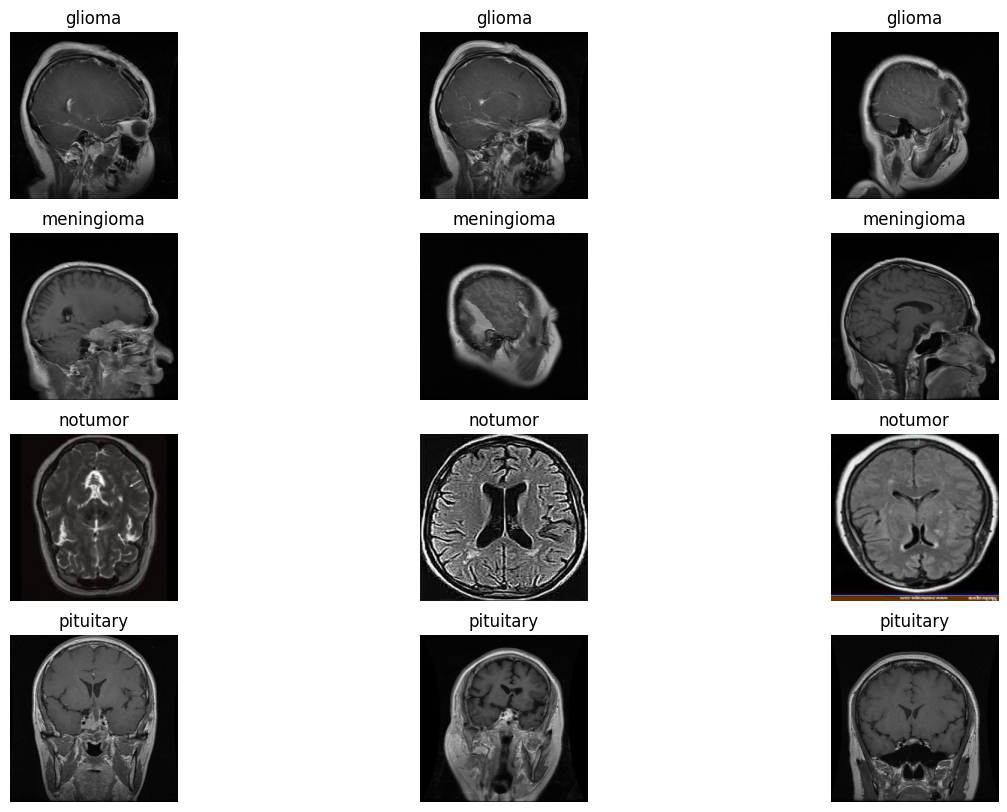

In [ ]:
# Define class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Visualize training data
show_sample_images(X_train, y_train, class_names)


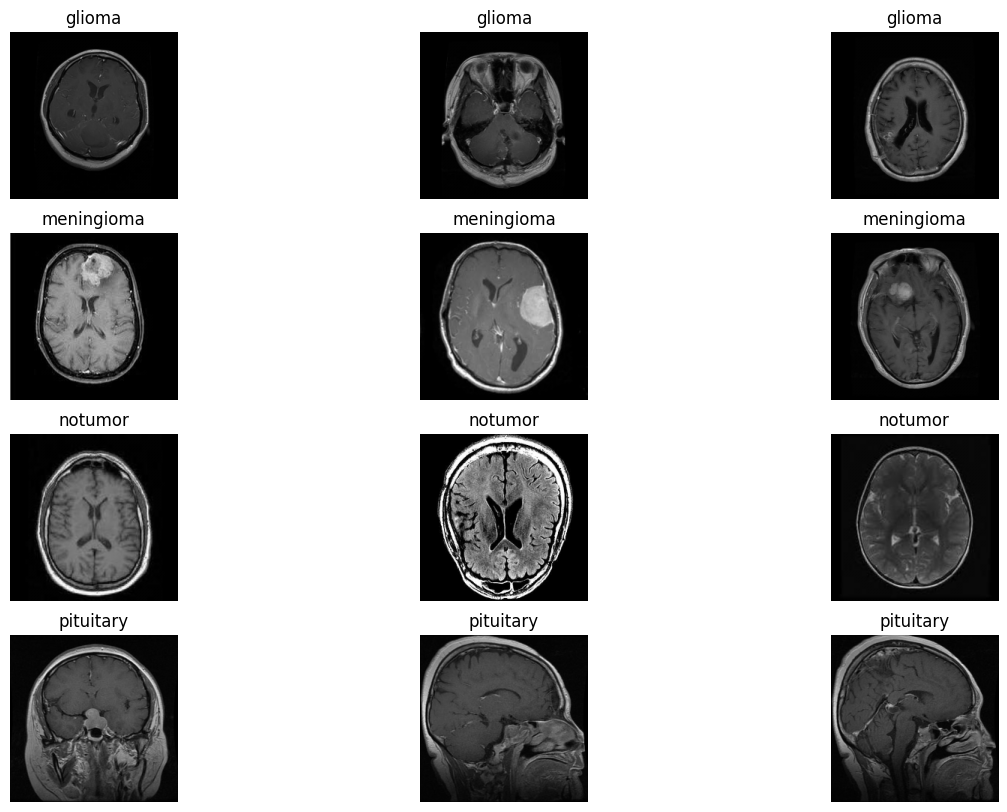

In [ ]:
# Visualize test data
show_sample_images(X_test, y_test, class_names)

In [ ]:
#Check the number of images in each class
def images_in_classes(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

train_count = images_in_classes(train_path)
test_count = images_in_classes(test_path)
print("Training class counts:", train_count)
print("Testing class counts:", test_count)

Training class counts: {'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
Testing class counts: {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


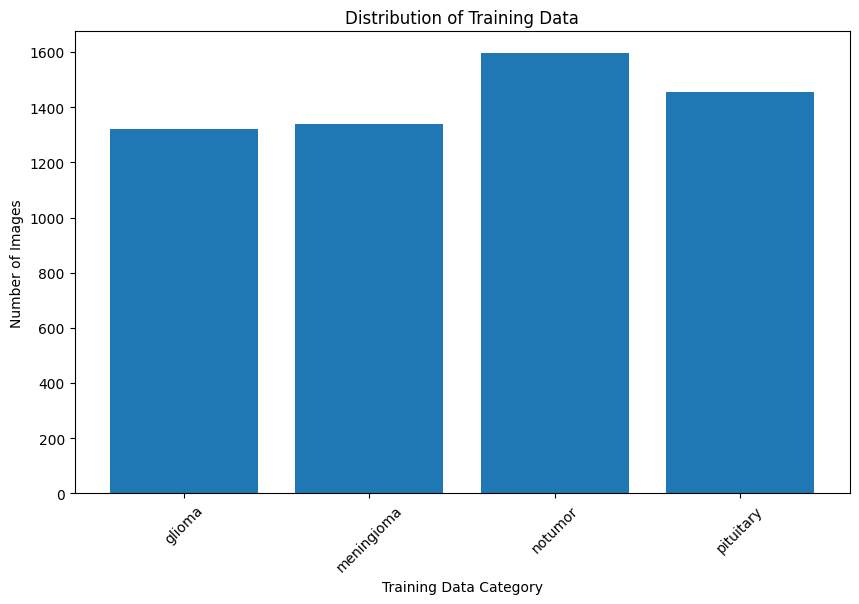

In [ ]:
 # Create a bar chart showing the distribution of Train data
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Training Data Category')
    plt.ylabel('Number of Images')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show
plot_class_distribution(train_count, 'Distribution of Training Data')




In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Create generators to load and preprocess the images
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size= size,
    batch_size=32,
    class_mode='categorical',

)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size= size,
    batch_size=32,
    class_mode='categorical',

)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Print class indices
print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

#verify images and labels are loaded correctly
images, labels = next(train_generator)
print("Batch shape:", images.shape, labels.shape)

Train classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Batch shape: (32, 224, 224, 3) (32, 4)


In [ ]:


# Load the VGG16 model
base_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
# Define the model
model = Sequential()
model.add(base_model)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes

# Freeze the base model
base_model.trainable = False


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 14847044 (56.64 MB)
Trainable params: 132356 (517.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("Model output shape:", model.output_shape)

X_train shape: (5712, 224, 224, 3)
y_train shape: (5712, 4)
Model output shape: (None, 4)


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
179/179 [==============================] - 46s 208ms/step - loss: 1.3179 - accuracy: 0.3785 - val_loss: 1.1266 - val_accuracy: 0.6560
Epoch 2/10
179/179 [==============================] - 26s 145ms/step - loss: 1.0559 - accuracy: 0.5928 - val_loss: 0.9757 - val_accuracy: 0.6743
Epoch 3/10
179/179 [==============================] - 27s 149ms/step - loss: 0.8942 - accuracy: 0.6982 - val_loss: 0.8705 - val_accuracy: 0.7094
Epoch 4/10
179/179 [==============================] - 27s 152ms/step - loss: 0.7904 - accuracy: 0.7491 - val_loss: 0.7964 - val_accuracy: 0.7277
Epoch 5/10
179/179 [==============================] - 28s 157ms/step - loss: 0.7141 - accuracy: 0.7771 - val_loss: 0.7469 - val_accuracy: 0.7437
Epoch 6/10
179/179 [==============================] - 28s 155ms/step - loss: 0.6563 - accuracy: 0.7883 - val_loss: 0.7023 - val_accuracy: 0.7567
Epoch 7/10
179/179 [==============================] - 28s 155ms/step - loss: 0.6183 - accuracy: 0.8046 - val_loss: 0.6729 - val_ac

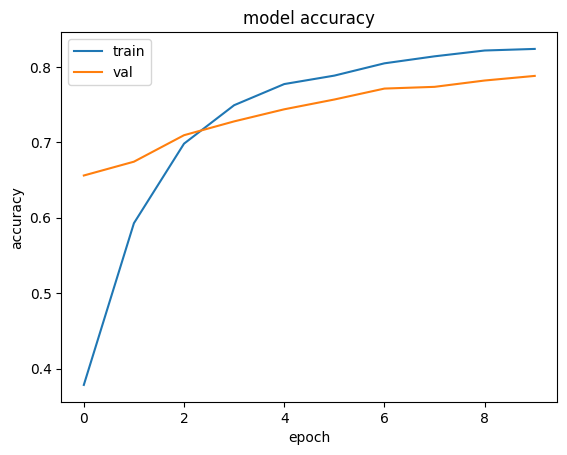

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

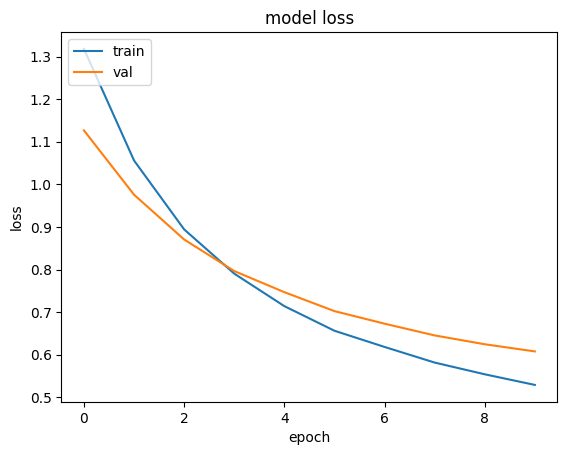

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


41/41 [==============================] - 6s 127ms/step - loss: 0.6079 - accuracy: 0.7857
Test loss: 0.607923150062561
Test accuracy: 0.7856597900390625


In [ ]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator)
print(f"Train loss: {train_loss}")
print(f"Train accuracy: {train_accuracy}")

179/179 [==============================] - 73s 408ms/step - loss: 0.6250 - accuracy: 0.7654
Train loss: 0.62497878074646
Train accuracy: 0.7654061913490295


In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 5s 124ms/step
              precision    recall  f1-score   support

      glioma       0.81      0.73      0.76       300
  meningioma       0.65      0.56      0.60       306
     notumor       0.89      0.88      0.89       405
   pituitary       0.76      0.96      0.85       300

    accuracy                           0.79      1311
   macro avg       0.78      0.78      0.77      1311
weighted avg       0.79      0.79      0.78      1311

[[218  63   4  15]
 [ 31 171  39  65]
 [ 15  23 357  10]
 [  6   6   1 287]]


In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the train set
y_pred = model.predict(X_train)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_train, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)


179/179 [==============================] - 23s 127ms/step
              precision    recall  f1-score   support

      glioma       0.86      0.80      0.83      1321
  meningioma       0.75      0.73      0.74      1339
     notumor       0.95      0.90      0.93      1595
   pituitary       0.84      0.96      0.89      1457

    accuracy                           0.85      5712
   macro avg       0.85      0.85      0.85      5712
weighted avg       0.85      0.85      0.85      5712

[[1057  209   16   39]
 [ 134  975   53  177]
 [  32   67 1439   57]
 [   7   43    8 1399]]


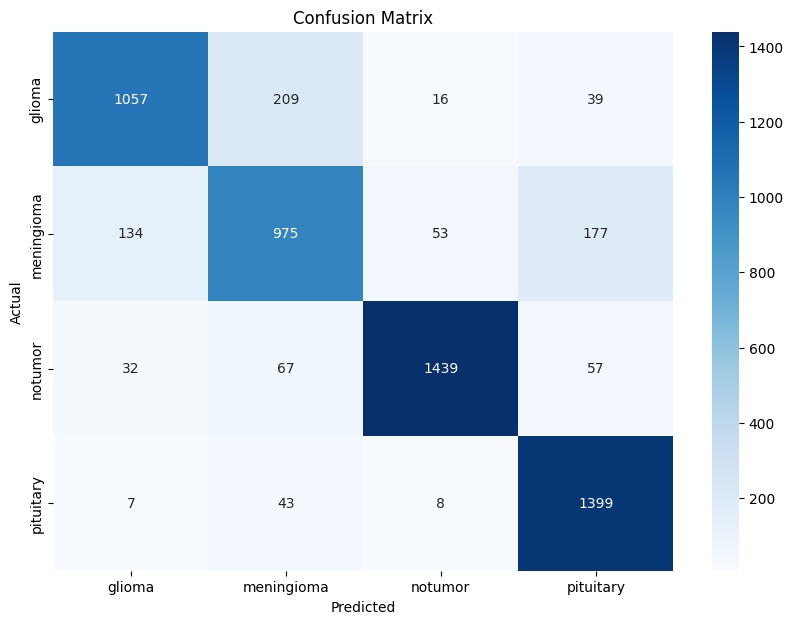

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
base_model = tf.keras.applications.resnet.ResNet50(include_top=False,
                                               weights='imagenet',
                                               input_shape=(224, 224, 3),
                                               pooling='avg')


94765736/94765736 [==============================] - 5s 0us/step


In [ ]:

model = Sequential()
model.add(base_model)

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(4, activation='softmax'))  # Adjust the number of output classes

# Freeze the base model
base_model.trainable = False



In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 24113284 (91.98 MB)
Trainable params: 525572 (2.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
179/179 [==============================] - 33s 152ms/step - loss: 1.3935 - accuracy: 0.3568 - val_loss: 1.2002 - val_accuracy: 0.5011
Epoch 2/10
179/179 [==============================] - 21s 117ms/step - loss: 1.1329 - accuracy: 0.5018 - val_loss: 1.1497 - val_accuracy: 0.5248
Epoch 3/10
179/179 [==============================] - 21s 115ms/step - loss: 1.0559 - accuracy: 0.5805 - val_loss: 1.0959 - val_accuracy: 0.6026
Epoch 4/10
179/179 [==============================] - 20s 115ms/step - loss: 1.0121 - accuracy: 0.6103 - val_loss: 1.0637 - val_accuracy: 0.5988
Epoch 5/10
179/179 [==============================] - 21s 116ms/step - loss: 0.9655 - accuracy: 0.6411 - val_loss: 1.0358 - val_accuracy: 0.6278
Epoch 6/10
179/179 [==============================] - 21s 116ms/step - loss: 0.9313 - accuracy: 0.6553 - val_loss: 1.0353 - val_accuracy: 0.5736
Epoch 7/10
179/179 [==============================] - 21s 116ms/step - loss: 0.9069 - accuracy: 0.6625 - val_loss: 0.9775 - val_ac

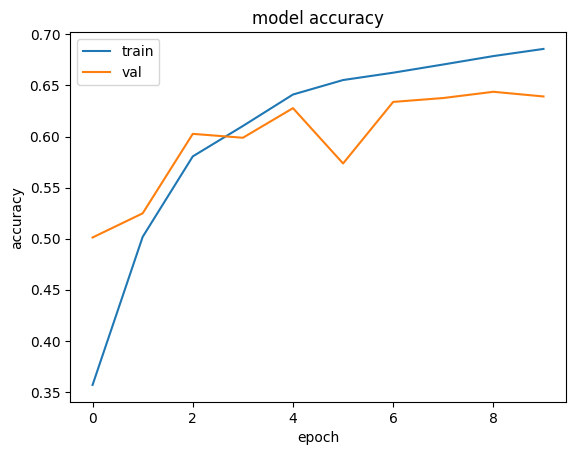

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

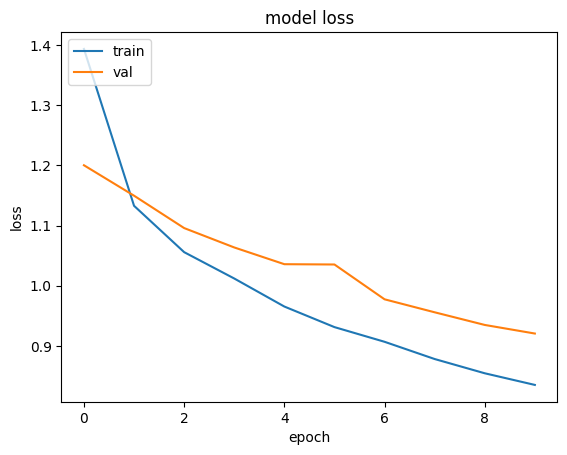

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")


41/41 [==============================] - 6s 121ms/step - loss: 0.8957 - accuracy: 0.6529
Test loss: 0.8956812620162964
Test accuracy: 0.6529366970062256


In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 5s 92ms/step
              precision    recall  f1-score   support

      glioma       0.55      0.61      0.58       300
  meningioma       0.50      0.40      0.44       306
     notumor       0.79      0.70      0.74       405
   pituitary       0.66      0.83      0.74       300

    accuracy                           0.64      1311
   macro avg       0.63      0.64      0.63      1311
weighted avg       0.64      0.64      0.63      1311

[[184  76   1  39]
 [ 65 121  68  52]
 [ 60  26 283  36]
 [ 25  19   6 250]]


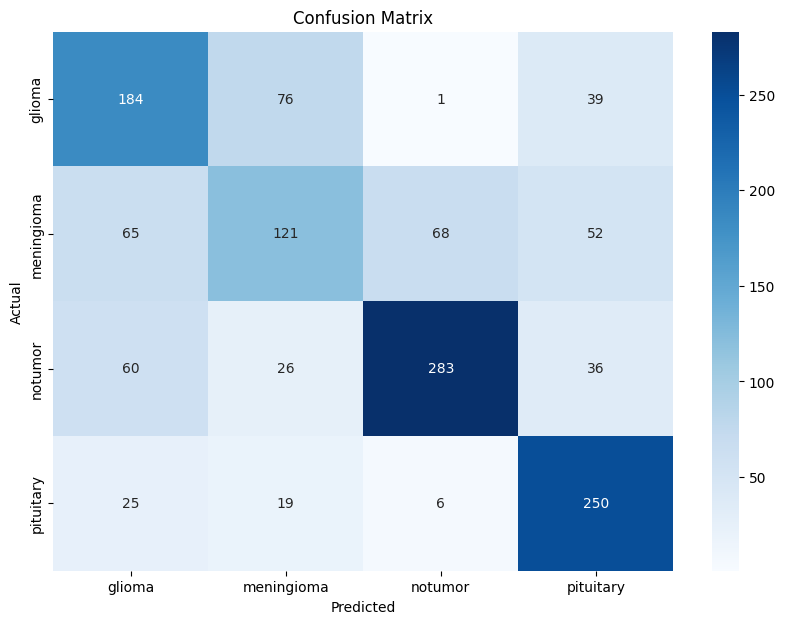

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Custom CNN Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


model = Sequential()
model.add(Conv2D(32, (3,3), activation= 'relu',input_shape=(224, 224, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation= 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation= 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3,3), activation= 'relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Added dropout for regularization
model.add(Dense(4, activation='softmax'))

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the ImageDataGenerator for the images with augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Display the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Epoch 1/10
179/179 [==============================] - 16s 68ms/step - loss: 0.8517 - accuracy: 0.6339 - val_loss: 0.6916 - val_accuracy: 0.7384
Epoch 2/10
179/179 [==============================] - 8s 47ms/step - loss: 0.5313 - accuracy: 0.7962 - val_loss: 0.5241 - val_accuracy: 0.7933
Epoch 3/10
179/179 [==============================] - 9s 48ms/step - loss: 0.4253 - accuracy: 0.8419 - val_loss: 0.4308 - val_accuracy: 0.8398
Epoch 4/10
179/179 [==============================] - 9s 48ms/step - loss: 0.3551 - accuracy: 0.8699 - val_loss: 0.3709 - val_accuracy: 0.8558
Epoch 5/10
179/179 [==============================] - 8s 47ms/step - loss: 0.3101 - accuracy: 0.8894 - val_loss: 0.3406 - val_accuracy: 0.8703
Epoch 6/10
179/179 [==============================] - 8s 47ms/step - loss: 0.2584 - accuracy: 0.9072 - val_loss: 0.3046 - val_accuracy: 0.8772
Epoch 7/10
179/179 [==============================] - 8s 47ms/step - loss: 0.2307 - accuracy: 0.9181 - val_loss: 0.2423 - val_accuracy: 0.905

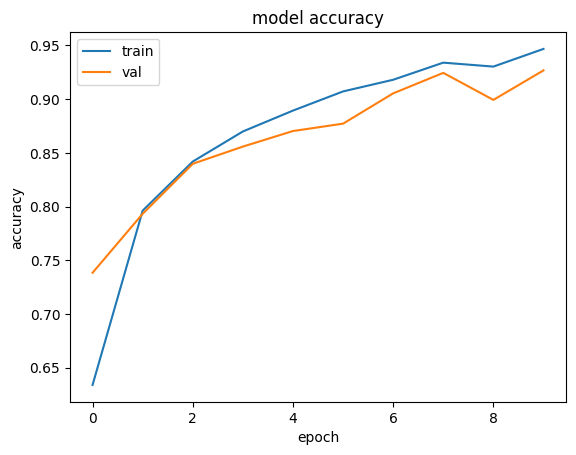

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

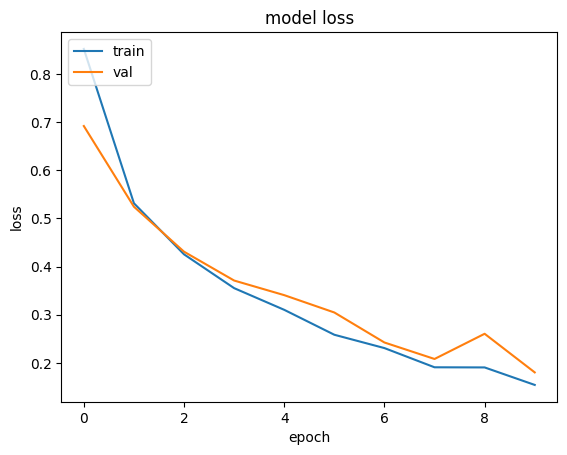

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)



41/41 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

      glioma       0.93      0.88      0.90       300
  meningioma       0.87      0.83      0.85       306
     notumor       0.94      1.00      0.97       405
   pituitary       0.96      0.98      0.97       300

    accuracy                           0.93      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311

[[263  33   1   3]
 [ 20 253  25   8]
 [  0   1 404   0]
 [  1   4   0 295]]


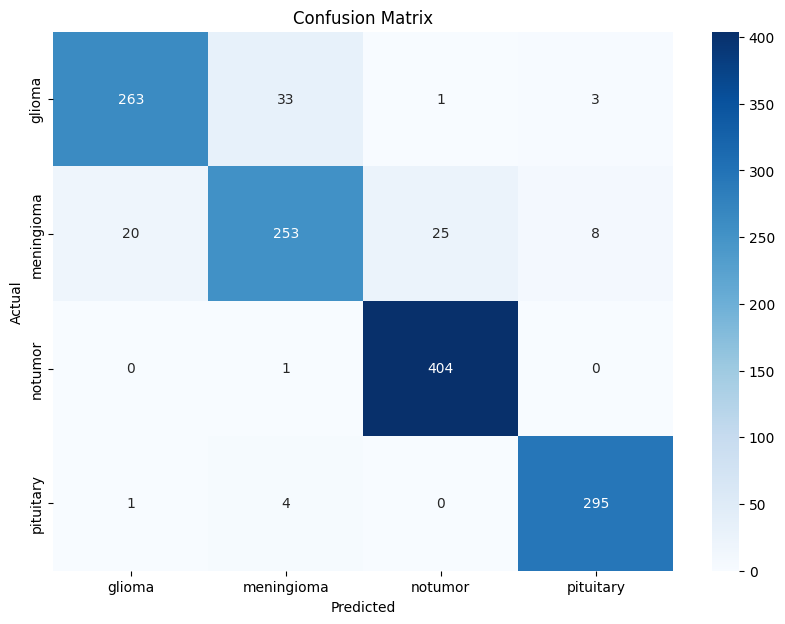

In [ ]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Hybrid Model